
# Automatic Ticket classification

In [1]:
import numpy as np
import json
import pandas as pd
import re
import spacy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
f = open('data/complaints.json')
data = json.load(f)
df = pd.json_normalize(data)
df.head(3)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided


In [4]:
# printing the shape for the dataframe
df.shape

(78313, 22)

### 4. Text cleaning and pre-processing 

In [6]:
# removing _source from column names
columns = df.columns
new_columns=[ column.replace("_source.","") for column in columns ]
df.columns = new_columns
df.head(3)

,_index,_type,_id,_score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided


#### 4.1. Handling missing values

In [7]:
# check the nan, and the empty string complaints
df['complaint_what_happened']=df['complaint_what_happened'].apply(lambda x: pd.NA if len(x)==0 else x)
df['complaint_what_happened'].isna().sum()

57241

In [9]:
df = df[~df['complaint_what_happened'].isna()]

#### 4.2. Text cleaning 


In [10]:
# define a function to perform basic text cleaning
def preprocess(text):
  # convert all characters to lowercase
  text = text.lower()
  text = re.sub(r'\[.*?\]','',text) # remove text in square brackets
  text = re.sub(r'[^\w\s]', '',text) # remove all punctuations
  text = re.sub(r'[\d]','',text) # remove all digits
  text = re.sub(r'[*x]?','',text) # remove masked characters
  return text

In [14]:
df['complaint_what_happened'] = df['complaint_what_happened'].astype(str)
df['complaint_pre_process'] = df['complaint_what_happened'].apply(preprocess)
df[['complaint_what_happened','complaint_pre_process']]

,complaint_what_happened,complaint_pre_process
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the a...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came a...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...
...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday i called chas my visa credit c...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with pay and did not unders...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had ch...


In [27]:
import spacy
model = spacy.load("en_core_web_sm")

def getLemma(text):
  modified_text =" "
  tokens = model(text)
  for token in tokens :
    if(token.tag_=='NN'):
       modified_text = modified_text + token.lemma_ +" "
  return modified_text


In [29]:
getLemma("""
Swifter is a library that can accelerate the apply process by utilizing parallel processing on multiple CPU cores.
This can significantly speed up the apply operation, especially for complex functions or large datasets. 
""")

' swifter library apply process processing cpu apply operation '

#### 4.3. Lemmatization
Most of the words that are important to identify a topic are nouns.The words which are not nouns can be removed. Getting the lemma of word is time consuming.

We can use `swifter` to optimize the process.

Swifter is a library that can accelerate the apply process by utilizing parallel processing on multiple CPU cores.

This can significantly speed up the apply operation, especially for complex functions or large datasets. 

In [31]:
import swifter
df['complaint_clean'] = df['complaint_pre_process'].swifter.apply(getLemma)

Pandas Apply: 100%|██████████| 21072/21072 [10:29<00:00, 33.45it/s]


In [32]:
complaint_pre_processed = df['complaint_clean'].tolist()

In [33]:
df[['complaint_pre_process','complaint_clean']]

,complaint_pre_process,complaint_clean
1,good morning my name is and i appreciate it ...,morning name stop bank cardmember debt verifi...
2,i upgraded my card in and was told by the a...,card agent anniversary date agent information...
10,chase card was reported on however fraudulent...,card application identity consent credit iden...
11,on while trying to book a ticket i came a...,ticket offer ticket card information offer mi...
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accou...
...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade credit chase bonus...
78309,on wednesday i called chas my visa credit c...,visa credit card provider claim purchase prot...
78310,i am not familiar with pay and did not unders...,pay risk chase bank app chase banking merchan...
78311,i have had flawless credit for yrs ive had ch...,credit yrs chase credit chase freedom balance...


### 5. Feature Extraction

In [35]:
# converting words to number using tfidf vectorizer
vect = TfidfVectorizer(stop_words='english')
X = vect.fit_transform(complaint_pre_processed)
X.shape

(21072, 13211)

### 6. Topic Modelling

In [36]:
# topic modelling using NMF
from sklearn.decomposition import NMF

nmf = NMF(n_components=5) # number of topics
W = nmf.fit_transform(X)
H = nmf.components_
print(W.shape)
print(H.shape)

(21072, 5)
(5, 13211)


In [37]:
# Printing the Top 10 words per topic
words = np.array(vect.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((5, 10)), index=[f'Topic {i + 1}' for i in range(5)],
                           columns=[f'Word {i + 1}' for i in range(10)]).astype(str)
for i in range(5):
    ix = H[i].argsort()[::-1][:10]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,account,bank,money,check,chase,branch,deposit,checking,number,business
Topic 2,card,chase,credit,charge,fraud,dispute,company,merchant,fee,purchase
Topic 3,loan,mortgage,chase,home,modification,property,foreclosure,letter,house,time
Topic 4,credit,report,inquiry,score,debt,reporting,account,information,limit,identity
Topic 5,payment,balance,month,fee,statement,date,auto,chase,time,day


In [38]:
colnames = ["Topic" + str(i) for i in range(nmf.n_components)]
docnames = ["Doc" + str(i) for i in range(len(complaint_pre_processed))]
df_doc_topic = pd.DataFrame(np.round(W, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.03,0.00,0.02,0.02,0.01,0
Doc1,0.01,0.02,0.00,0.00,0.00,1
Doc2,0.00,0.02,0.00,0.03,0.00,3
Doc3,0.02,0.02,0.01,0.05,0.00,3
Doc4,0.07,0.01,0.01,0.00,0.00,0


In [39]:
# creating a dictionary to map the labels to corresponding categories.
topics ={
    0: 'bank account services',
    1: 'credit_card',
    2: 'mortgage/loans',
    3: 'theft/dispute reporting',
    4: 'others'
}

# getting the dominant topic assigned the maximum weight
df['max_topic']=W.argmax(axis=1)

# mapping the max topic to the categories using topic dictionary
df['topic_category']= df['max_topic'].map(topics)

# let's print few complaints in each topic
df[['complaint_clean','topic_category']].head()

,complaint_clean,topic_category
1,morning name stop bank cardmember debt verifi...,bank account services
2,card agent anniversary date agent information...,credit_card
10,card application identity consent credit iden...,theft/dispute reporting
11,ticket offer ticket card information offer mi...,theft/dispute reporting
14,son check chase account fund chase bank accou...,bank account services


#### Lets check if there is any class imbalance

<Axes: xlabel='topic_category', ylabel='count'>

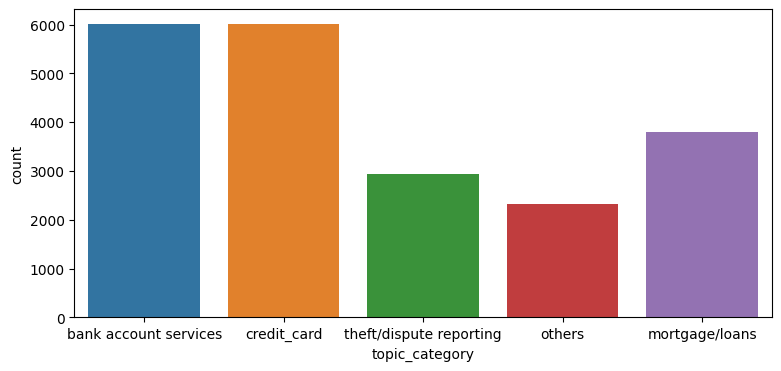

In [41]:
# distribution of the topics
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9,4))
sns.countplot(data=df, x='topic_category', hue='topic_category')

## 7. Model Training

In [42]:
from sklearn.model_selection import train_test_split

X_transformed = X.toarray()
y = df['max_topic']

X_train,X_test,y_train,y_test = train_test_split(X_transformed,y,test_size=0.2)

print(f"training data size:{X_train.shape}")
print(f"training data size:{X_test.shape}")

training data size:(16857, 13211)
training data size:(4215, 13211)


In [43]:
# training a classification model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold

In [61]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [44]:
lr = LogisticRegression().fit()

In [ ]:
lr = LogisticRegression()

# defining hyper-parameters to be fine-tuned
param_grid ={
    'C':[
        0.1, 
        # 1
    ],
    'penalty':[
        # 'l1',
        'l2'
    ]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
gridsearch = GridSearchCV(lr, param_grid, cv=cv, n_jobs=-1)
gridsearch.fit(X_train,y_train)

In [47]:
model = gridsearch.best_estimator_
model

LogisticRegression(C=0.1)

#### Model Evaluation

In [48]:
# printing the performance summary of logistic regression
from sklearn.metrics import classification_report, accuracy_score

y_test_predicted = model.predict(X_test)

y_test_predicted

array([3, 4, 2, ..., 4, 0, 0])

In [50]:
print("Classification report on test data\n")
print(classification_report(y_test, y_test_predicted))

accuracy=accuracy_score(y_test,y_test_predicted)
print(f"Accuracy on test data: {accuracy}")

Classification report on test data

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1191
           1       0.91      0.99      0.95      1172
           2       0.94      0.96      0.95       773
           3       0.98      0.86      0.92       607
           4       0.99      0.76      0.86       472

    accuracy                           0.94      4215
   macro avg       0.95      0.91      0.93      4215
weighted avg       0.94      0.94      0.94      4215

Accuracy on test data: 0.937841043890866


### 8. Save model with pickle

From the results it is seen that logistic regression with hyper-paramter tuning performs better than xgboost. We can experiment further by hyperparamter tuning xgboost algorithm. For now we will use logistic regression model for prediction

In [51]:
# dump final model and tf_idf vector
import pickle


with open('../src/model/logistic_model.pkl','wb') as f:
  pickle.dump(model, f)

# Export the same TF-IDF vectorization to the preprocessed input text on the client side.
# We need to ensure that the TF-IDF vectorization is consistent with what was used during training.
with open('../src/model/tf_idf.pkl','wb') as f:
  pickle.dump(vect, f)

### XGBoost classifier (optional)

In [66]:
import xgboost as xgb

In [69]:
xgb = xgb.XGBClassifier(random_state=42,n_jobs=-1, objective='multi:softmax')
xgb.fit(X_train,y_train)

In [69]:
# printing the performance summary of xgboost 
y_test_pred = xgb.predict(X_test)
print("classification report \n")
print(classification_report(y_test,y_test_pred))

accuracy = accuracy_score(y_test,y_test_pred)
print(f"test accuracy: {accuracy}")

classification report 

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1165
           1       0.92      0.95      0.93      1237
           2       0.91      0.91      0.91       768
           3       0.93      0.88      0.90       586
           4       0.93      0.88      0.90       459

    accuracy                           0.92      4215
   macro avg       0.92      0.91      0.92      4215
weighted avg       0.92      0.92      0.92      4215

test accuracy: 0.9238434163701068
